In [1]:
import matplotlib
import matplotlib.pyplot
import matplotlib.style
import PIL.Image
import numpy
import sympy
import sympy.printing
import sympy.utilities
import scipy.io as sio
matplotlib.rcParams["figure.figsize"] = [12, 6]
matplotlib.style.use("dark_background")
sympy.init_printing(use_latex=True)

We introduce normalised variables to simplify the equations:
- normalised x pixel position `px = x / w`
- normalised y pixel position `p_y = y / h`
- normalised shear x `sx = delta * v_x / w`
- normalised shear y `sy = delta * v_y / h`
- count `c = delta * rho`

In [2]:
# c0 := s_x < 1 ^ s_y < 1

# c, p_x, p_y in ]0, +oo[
c, p_x, p_y = sympy.symbols("c p_x p_y", real=True, positive=True)

# s_x, s_y in ]0, 1[
s_x0, s_y0 = sympy.symbols("s_x0 s_y0", real=True, positive=True)
s_x1 = s_x0 + 1
s_y1 = s_y0 + 1
s_x = 1 / s_x1
s_y = 1 / s_y1

f0 = c * p_y / s_y
f1 = c * p_x / s_x
f2 = c * p_y / s_y
f3 = c * p_x / s_x
f4 = c
f5 = c * (1 / s_x - p_x / s_x + p_y / s_y)

In [3]:
integral0: sympy.Expr = sympy.integrate(
    f0, (p_y, 0, s_y / s_x * p_x), (p_x, 0, s_x)
).simplify()
integral1: sympy.Expr = sympy.integrate(
    f1, (p_x, 0, s_x / s_y * p_y), (p_y, 0, s_y)
).simplify()
integral2: sympy.Expr = sympy.integrate(f2, (p_x, s_x, 1), (p_y, 0, s_y)).simplify()
integral3: sympy.Expr = sympy.integrate(f3, (p_x, 0, s_x), (p_y, s_y, 1)).simplify()
integral4: sympy.Expr = sympy.integrate(f4, (p_x, s_x, 1), (p_y, s_y, 1)).simplify()
integral5: sympy.Expr = sympy.integrate(
    f5, (p_y, (p_x - 1) * s_y / s_x, s_y), (p_x, 1, 1 + s_x)
).simplify()

mu_with_assumptions = (
    (
        integral0 * 2
        + integral1 * 2
        + integral2 * 2
        + integral3 * 2
        + integral4
        + integral5 * 2
    )
    / ((1 + s_x) * (1 + s_y) - s_x * s_y)
).simplify()

variance_integral0: sympy.Expr = sympy.integrate(
    (f0 - mu_with_assumptions) ** 2, (p_y, 0, s_y / s_x * p_x), (p_x, 0, s_x)
).simplify()
variance_integral1: sympy.Expr = sympy.integrate(
    (f1 - mu_with_assumptions) ** 2, (p_x, 0, s_x / s_y * p_y), (p_y, 0, s_y)
).simplify()
variance_integral2: sympy.Expr = sympy.integrate(
    (f2 - mu_with_assumptions) ** 2, (p_x, s_x, 1), (p_y, 0, s_y)
).simplify()
variance_integral3: sympy.Expr = sympy.integrate(
    (f3 - mu_with_assumptions) ** 2, (p_x, 0, s_x), (p_y, s_y, 1)
).simplify()
variance_integral4: sympy.Expr = sympy.integrate(
    (f4 - mu_with_assumptions) ** 2, (p_x, s_x, 1), (p_y, s_y, 1)
).simplify()
variance_integral5: sympy.Expr = sympy.integrate(
    (f5 - mu_with_assumptions) ** 2,
    (p_y, (p_x - 1) * s_y / s_x, s_y),
    (p_x, 1, 1 + s_x),
).simplify()

variance_with_assumptions = (
    (
        variance_integral0 * 2
        + variance_integral1 * 2
        + variance_integral2 * 2
        + variance_integral3 * 2
        + variance_integral4
        + variance_integral5 * 2
    )
    / ((1 + s_x) * (1 + s_y) - s_x * s_y)
).simplify()

In [4]:
# re-introduce variables to clear bindings
s_x0, s_y0, s_x1, s_y1, s_x, s_y = sympy.symbols("s_x0 s_y0 s_x1 s_y1 s_x s_y", real=True, positive=True)

mu_c0 = mu_with_assumptions.subs(s_x0, 1 / s_x - 1).subs(s_y0, 1 / s_y - 1).simplify().factor()
variance_c0 = variance_with_assumptions.subs(s_x0, 1 / s_x - 1).subs(s_y0, 1 / s_y - 1).simplify().factor()

In [5]:
print(sympy.printing.latex(mu_c0))
mu_c0

\frac{c}{s_{x} + s_{y} + 1}


\frac{c^{2} \left(s_{x}^{2} s_{y} - 2 s_{x}^{2} + s_{x} s_{y}^{2} - 3 s_{x} s_{y} + 4 s_{x} - 2 s_{y}^{2} + 4 s_{y}\right)}{6 \left(s_{x} + s_{y} + 1\right)^{2}}


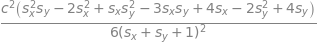

In [6]:
print(sympy.printing.latex(variance_c0))
variance_c0

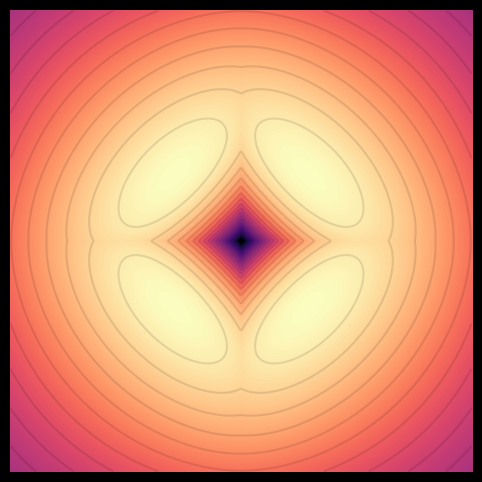

In [7]:
variance_c0_lambda = sympy.utilities.lambdify((s_x, s_y), variance_c0.subs(c, 1.0))

points = 200
s_x_grid = numpy.repeat(numpy.linspace(0.0, 1.0, points, endpoint=False), points)
s_y_grid = numpy.tile(numpy.linspace(0.0, 1.0, points, endpoint=False), points)

image = PIL.Image.fromarray(
    numpy.vectorize(variance_c0_lambda)(s_x_grid, s_y_grid).reshape((points, points))
)
tiled_image = PIL.Image.new(size=(points * 2, points * 2), mode=image.mode)
tiled_image.paste(image, box=(points, points, points + points, points + points))
tiled_image.paste(
    image.transpose(PIL.Image.Transpose.FLIP_TOP_BOTTOM),
    box=(points, 0, points + points, points),
)
tiled_image.paste(
    image.transpose(PIL.Image.Transpose.FLIP_LEFT_RIGHT),
    box=(0, points, points, points + points),
)
tiled_image.paste(
    image.transpose(PIL.Image.Transpose.ROTATE_180), box=(0, 0, points, points)
)
tiled = numpy.array(tiled_image)

matplotlib.pyplot.imshow(
    tiled,
    origin="lower",
    cmap="magma",
)
matplotlib.pyplot.contour(tiled, levels=20, colors="#000000", alpha=0.1)
matplotlib.pyplot.axis("off")

In [8]:
# c1 := s_x > 1 ^ s_y < s_x

# c, p_x, p_y in ]0, +oo[
c, p_x, p_y = sympy.symbols("c p_x p_y", real=True, positive=True)

# s_x in  ]1, +oo[, s_y in ]0, 1[ (implies s_y < s_x)
s_x0, s_y0 = sympy.symbols("s_x0 s_y0", real=True, positive=True)
s_y1 = s_y0 + 1
s_x = s_x0 + 1
s_y = 1 / s_y1

f0 = c * p_y / s_y
f1 = c * p_x / s_x
f2 = c * (1 / s_x - p_x / s_x + p_y / s_y)
f3 = c * p_x / s_x
f4 = c / s_x
f5 = c * (1 / s_x - p_x / s_x + p_y / s_y)

In [9]:
integral0: sympy.Expr = sympy.integrate(
    f0, (p_y, 0, s_y / s_x * p_x), (p_x, 0, 1)
).simplify()
integral1: sympy.Expr = sympy.integrate(
    f1, (p_x, 0, s_x / s_y * p_y), (p_y, 0, s_y / s_x)
).simplify()
integral2: sympy.Expr = sympy.integrate(
    f2,
    (p_y, (p_x - 1) * s_y / s_x, p_x * s_y / s_x),
    (p_x, 1, s_x),
).simplify()
integral3: sympy.Expr = sympy.integrate(f3, (p_x, 0, 1), (p_y, s_y / s_x, 1)).simplify()
integral4: sympy.Expr = sympy.integrate(
    f4,
    (p_y, p_x * s_y / s_x, (p_x - 1) * s_y / s_x + 1),
    (p_x, 1, s_x),
).simplify()
integral5: sympy.Expr = sympy.integrate(
    f5,
    (p_y, (p_x - 1) * s_y / s_x, s_y),
    (p_x, s_x, 1 + s_x),
).simplify()

mu_with_assumptions = (
    (
        integral0 * 2
        + integral1 * 2
        + integral2 * 2
        + integral3 * 2
        + integral4
        + integral5 * 2
    )
    / ((1 + s_x) * (1 + s_y) - s_x * s_y)
).simplify()

variance_integral0: sympy.Expr = sympy.integrate(
    (f0 - mu_with_assumptions) ** 2, (p_y, 0, s_y / s_x * p_x), (p_x, 0, 1)
).simplify()
variance_integral1: sympy.Expr = sympy.integrate(
    (f1 - mu_with_assumptions) ** 2, (p_x, 0, s_x / s_y * p_y), (p_y, 0, s_y / s_x)
).simplify()
variance_integral2: sympy.Expr = sympy.integrate(
    (f2 - mu_with_assumptions) ** 2,
    (p_y, (p_x - 1) * s_y / s_x, p_x * s_y / s_x),
    (p_x, 1, s_x),
).simplify()
variance_integral3: sympy.Expr = sympy.integrate(
    (f3 - mu_with_assumptions) ** 2, (p_x, 0, 1), (p_y, s_y / s_x, 1)
).simplify()
variance_integral4: sympy.Expr = sympy.integrate(
    (f4 - mu_with_assumptions) ** 2,
    (p_y, p_x * s_y / s_x, (p_x - 1) * s_y / s_x + 1),
    (p_x, 1, s_x),    
).simplify()
variance_integral5: sympy.Expr = sympy.integrate(
    (f5 - mu_with_assumptions) ** 2,
    (p_y, (p_x - 1) * s_y / s_x, s_y),
    (p_x, s_x, 1 + s_x),
).simplify()

variance_with_assumptions = (
    (
        variance_integral0 * 2
        + variance_integral1 * 2
        + variance_integral2 * 2
        + variance_integral3 * 2
        + variance_integral4
        + variance_integral5 * 2
    )
    / ((1 + s_x) * (1 + s_y) - s_x * s_y)
).simplify()

In [10]:
# re-introduce variables to clear bindings
s_x0, s_y0, s_y1, s_x, s_y = sympy.symbols("s_x0 s_y0  s_y1 s_x s_y", real=True, positive=True)

mu_c1 = mu_with_assumptions.subs(s_x0, s_x - 1).subs(s_y0, 1 / s_y - 1).simplify().factor()
variance_c1 = variance_with_assumptions.subs(s_x0, s_x - 1).subs(s_y0, 1 / s_y - 1).simplify().factor()

In [11]:
print(sympy.printing.latex(mu_c1))
mu_c1

\frac{c}{s_{x} + s_{y} + 1}


\frac{c^{2} \cdot \left(4 s_{x}^{2} s_{y} + 4 s_{x}^{2} - 2 s_{x} s_{y}^{2} - 3 s_{x} s_{y} - 2 s_{x} + s_{y}^{2} + s_{y}\right)}{6 s_{x}^{3} \left(s_{x} + s_{y} + 1\right)^{2}}


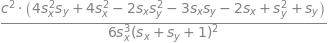

In [12]:
print(sympy.printing.latex(variance_c1))
variance_c1

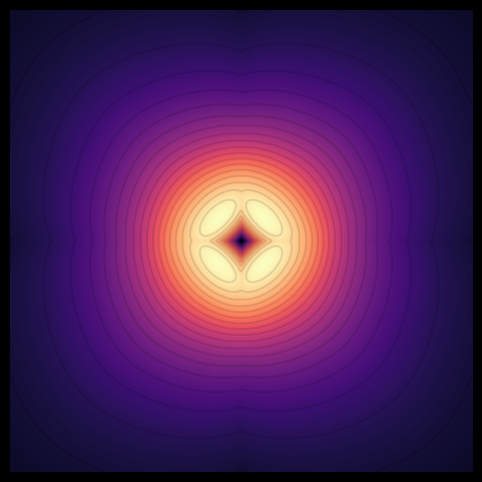

In [13]:
variance_c0_lambda = sympy.utilities.lambdify((s_x, s_y), variance_c0.subs(c, 1.0))
variance_c1_lambda = sympy.utilities.lambdify((s_x, s_y), variance_c1.subs(c, 1.0))

RESOLUTION = 200
MAXIMUM = 3.0
s_x_grid = numpy.tile(
    numpy.linspace(0.0, MAXIMUM, RESOLUTION, endpoint=False), RESOLUTION
)
s_y_grid = numpy.repeat(
    numpy.linspace(0.0, MAXIMUM, RESOLUTION, endpoint=False), RESOLUTION
)
points = numpy.column_stack((s_x_grid, s_y_grid))
image_array = numpy.zeros((RESOLUTION, RESOLUTION))

variance_c0_image = numpy.vectorize(variance_c0_lambda)(
    points[:, 0], points[:, 1]
).reshape((RESOLUTION, RESOLUTION))
mask = numpy.logical_and(points[:, 0] <= 1.0, points[:, 1] <= 1.0)
numpy.ravel(image_array)[mask] = numpy.ravel(variance_c0_image)[mask]


variance_c1_image = numpy.vectorize(variance_c1_lambda)(
    numpy.maximum(points[:, 0], 1.0), points[:, 1]
).reshape((RESOLUTION, RESOLUTION))
mask = numpy.logical_and(points[:, 0] > 1.0, points[:, 1] <= points[:, 0])
numpy.ravel(image_array)[mask] = numpy.ravel(variance_c1_image)[mask]

variance_c2_image = numpy.vectorize(variance_c1_lambda)(
    numpy.maximum(points[:, 1], 1.0), points[:, 0]
).reshape((RESOLUTION, RESOLUTION))
mask = numpy.logical_and(points[:, 1] > 1.0, points[:, 0] < points[:, 1])
numpy.ravel(image_array)[mask] = numpy.ravel(variance_c2_image)[mask]

image = PIL.Image.fromarray(image_array)

tiled_image = PIL.Image.new(size=(RESOLUTION * 2, RESOLUTION * 2), mode=image.mode)
tiled_image.paste(image, box=(RESOLUTION, RESOLUTION, RESOLUTION + RESOLUTION, RESOLUTION + RESOLUTION))
tiled_image.paste(
    image.transpose(PIL.Image.Transpose.FLIP_TOP_BOTTOM),
    box=(RESOLUTION, 0, RESOLUTION + RESOLUTION, RESOLUTION),
)
tiled_image.paste(
    image.transpose(PIL.Image.Transpose.FLIP_LEFT_RIGHT),
    box=(0, RESOLUTION, RESOLUTION, RESOLUTION + RESOLUTION),
)
tiled_image.paste(
    image.transpose(PIL.Image.Transpose.ROTATE_180), box=(0, 0, RESOLUTION, RESOLUTION)
)
tiled = numpy.array(tiled_image)

matplotlib.pyplot.imshow(
    tiled,
    origin="lower",
    cmap="magma",
)
matplotlib.pyplot.contour(tiled, levels=20, colors="#000000", alpha=0.1)
matplotlib.pyplot.axis("off")
# matplotlib.pyplot.savefig('tiled.png')
sio.savemat('tiled0_v1.mat',  {'tiled': numpy.asarray(tiled)})